In this notebook you will learn step by step how to create a transmission spectrum on one night of HARPS data taken as part of the HEARTS survey which is now publicly available (WASP-76b, night 2012-11-11). For a full analysis of this dataset, check out Seidel et al. 2019 (https://ui.adsabs.harvard.edu/abs/2019A%26A...623A.166S/abstract).
If you have questions reach out to us: Julia Seidel (julia.seidel@unige.ch) and Núria Casasayas-Barris (barris@strw.leidenuniv.nl)

# Assumptions

For the sake of time, we make some assumptions which you will have to perform by yourself in a real scenario:
1. The telluric correction has been performed
2. The data quality of the night has been assessed (S/N, telluric sodium emission, cosmics, contamination from the interstellar medium)
3. The ephemeris was calculated correctly and the in and out of transit data points were separated properly taking into account the information provided in the file headers. That means we know all the velocities for each data point and whether they were taken in or out of transit.
4. The RM effect was assessed and if needed, corrected.
5. The overlap between the stellar and planetary lines was assessed and if needed the low S/N areas masked.
6. We will ignore the error on the data and all error propagations. If you want to, calculate the error and propagate it as you go.

# Building the transmission spectrum pipeline

First you will have to load the necessary packages:

In [ ]:
from scipy.optimize import newton
from scipy import ndarray, interpolate
import numpy as np
import matplotlib.pyplot as plt

Next, you will have to download the datasets


In [ ]:
#from google.colab import drive #uncomment to load locally from google drive
#drive.mount('/content/drive', force_remount=True)
#root = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


Now we will load our datasets into the Jupyter notebook:

In [ ]:
 !git clone https://github.com/JVSeidel/Atmo_2021_highres_data      #Uncomment to get the data from the github repository  
!unzip Atmo_2021_highres_data/WASP76_HARPS.zip

Cloning into 'Atmo_2021_highres_data'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
Archive:  Atmo_2021_highres_data/WASP76_HARPS.zip
  inflating: W76_BERV.npy            
  inflating: __MACOSX/._W76_BERV.npy  
  inflating: W76_data_flux.npy       
  inflating: __MACOSX/._W76_data_flux.npy  
  inflating: W76_inTransit.npy       
  inflating: __MACOSX/._W76_inTransit.npy  
  inflating: W76_vel_planet.npy      
  inflating: __MACOSX/._W76_vel_planet.npy  
  inflating: W76_vel_star.npy        
  inflating: __MACOSX/._W76_vel_star.npy  
  inflating: W76_wavelength.npy      
  inflating: __MACOSX/._W76_wavelength.npy  


In [ ]:

data = np.load('W76_data_flux.npy', allow_pickle=True)
phase = np.load('W76_inTransit.npy', allow_pickle=True)
vel_star = np.load('W76_vel_star.npy', allow_pickle=True)
berv = np.load('W76_BERV.npy', allow_pickle=True)
vel_planet = np.load('W76_vel_planet.npy', allow_pickle=True)
wave = np.load('W76_wavelength.npy', allow_pickle=True)

#system velocity
v_sys = -1110.

Now plot the first exposure as a function of wavelength:

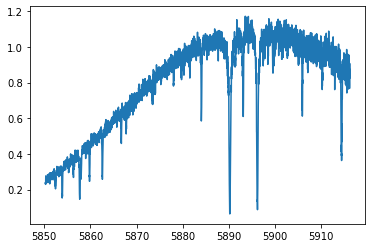

In [ ]:
plt.plot(wave[0],data[0])
plt.show()

Here data is a 2D numpy array containing all the spectra taken during the night as a function of wavelength, phase is a 1D boolean array telling us which spectra were taken in transit (True), vel_star is a 1D array with the relative velocity of the star at each exposure, similarly for vel_planet (relative velocity of the planet), and berv (barycentric earth radial velocity). Wave is a 1D array containing the inital wavelength solution in the observer's rest frame. v_sys is the system velocity, the velocity with which the planetary system moves with respect to the barycentre of our solar system. All velocities are given in km/s.

## Shifting all spectra into the stellar rest frame

Question: What is the purpose of shifting to the stellar rest frame?

Answer: The stellar lines are aligned in the stellar rest frame. By taking the spectra without planetary signal in the stellar rest frame and combining them we can divide out all stellar spectral lines from the in-transit exposures, leaving us only with the planetary signal.

The wavelength solution is not constant in wavelength space, but in velocity space. Therefore we will shift the spectra via the Doppler-Effect into the stellar rest frame (SRF) in velocity space.

Question: What velocities do we have to account for to shift the spectra into the SRF?

Answer: We need to account for the BERV, the system velocity, and the velocity of the star.

Question: What is the combined velocity we have to shift for? Write a function that will shift all spectra into the SRF and name it vel_rebin(insert the appropriate arguments in here).
Hints: One bin in velocity space for HARPS is 820 m/s wide. When shifting the spectra, the edges will not align anymore, so you will have to cut off the edges accordingly. You will need to interpolate on the data. Use the following function to do so:

In [ ]:
def spline_inter(x, y, xnew, k):
    """
        NB:
        -if k=1, we have a strict linear interpolation
        -scipy.interpolate.interp1d(x, y, kind='linear') equivalent as if if k=1
        -scipy.interpolate.interp1d(x, y, kind='cubic') slighly different (but near, see cases) as if if k=3
        
        if y is shifted like
        y[a+shift:b+shift]
        or xnew = x + shift
        or x = x - shift
        then: -shift>0 => ynew is blue shift
        -shift<0 => ynew is red shift
        NB: Be careful to the scale (not the same shift in x or y)
        
        keyword arguments:
        x -- Old x axis
        y -- Old y axis
        xnew -- New x axis
        k -- The Spline Order (1=linear, 3=cubic)
        
        """
    
    splflux = interpolate.InterpolatedUnivariateSpline(x, y, k=k)
   
    return splflux(xnew)

To calculate what the maximum cut off on each side has to be to realign all spectra, use the following function:

In [ ]:
def calc_max_shift(velocity_list,pixel_size=820.):
    nb_pixels = [rad_vel/pixel_size for rad_vel in list(velocity_list)]
    cutoff= int(round(abs(max(nb_pixels,key=abs))))
    return cutoff

Answer:

In [ ]:
def vel_rebin(vel_total,bin_set,data_pix,wave_set, cutoff,pixel_size=820.):
    """
        Function that shifts all spectra by a velocity array and then realigns them
        INPUT: vel_total: array of the velocities (1D)
               bin_set: 1D array of the bins
               data_pix: 1D array of the spectral data, one axis wavelength bins
               wave_set: array of the wavelength axis
               cutoff: maximum number of bins that have to be discarded on the sides to not create empty bins
               pixel_size: optional. default value is the HARPS pixel size= 820 m/s
        OUTPUT: data_pix_shift: new array of the shifted data
                bin_set_shift: new bin array
                wave_set_shift: shifted wavelength array
        """
    pixel_shift = vel_total/pixel_size

    bin_set_shift=bin_set[cutoff:len(data_pix)-cutoff]
    wave_set_shift=wave_set[cutoff:len(data_pix)-cutoff]
    
    data_pix_shift=np.empty(len(bin_set_shift))
   
    data_pix_shift_interm = spline_inter(bin_set, data_pix, bin_set+pixel_shift, 1)

    data_pix_shift = data_pix_shift_interm[cutoff:len(data_pix_shift_interm)-cutoff]
   
    return data_pix_shift,  bin_set_shift, wave_set_shift

The total velocity we have to account for is:

In [ ]:
vel_stellar_shift = -berv  + vel_star - v_sys

Question: Apply the shift into the SRF to all spectra.

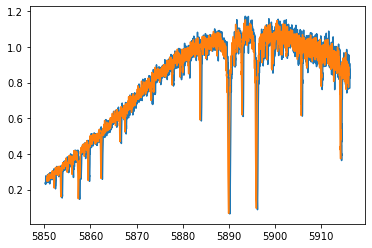

In [ ]:
cutoff = calc_max_shift(vel_stellar_shift)

bin_obs = np.arange(len(data[0]))
data_SRF = np.zeros(shape=(len(data),4062))
wave_SRF = np.zeros(shape=(len(data),4062))
plt.plot(wave[0],data[0])

for k in range(len(data)):
    data_SRF[k], bin_shift, wave_SRF[k] = vel_rebin(vel_stellar_shift[k] ,bin_obs ,data[k], wave[k], cutoff)

plt.plot(wave_SRF[0],data_SRF[0])
plt.show()

## Separating the planetary signal from the stellar spectral lines

Now all stellar spectral lines are in the correct position. Make sure that you did the correct shifts by looking at the master out spectrum (sum over all the out of transit spectra). Save the spectra, we will need it right away. Don't forget to normalise!
Answer:

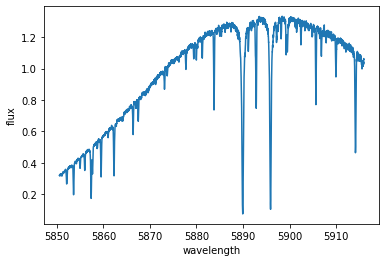

In [ ]:
master_out_SRF = np.sum(np.asarray(data_SRF)[list(~np.asarray(phase))],axis = 0)
norm_out_SRF = np.mean(master_out_SRF)
master_out_SRF = np.true_divide(master_out_SRF, norm_out_SRF)

plt.plot(wave_SRF[0],master_out_SRF)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()

And with that, the hardest part is done!

Question: Use the master out you just created to separate the planetary signal in the in transit spectra from the stellar spectral lines.

In [ ]:
in_transit_SRF = np.true_divide(np.asarray(data_SRF)[list(np.asarray(phase))],master_out_SRF)
wave_in_transit_SRF = wave_SRF[list(np.asarray(phase))]

## Build the transmission spectrum of the night

Question: What has to be done to align all the planetary spectral lines? What velocities do you need to arrive in this planetary rest frame (PRF)?

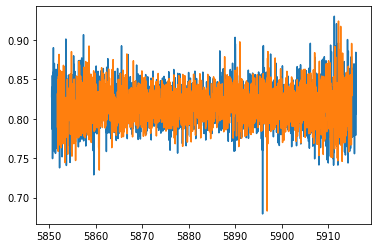

In [ ]:
vel_planetary_shift = - vel_star + vel_planet
vel_planetary_shift = vel_planetary_shift[list(np.asarray(phase))]
cutoff = calc_max_shift(vel_planetary_shift)
bin_SRF = np.arange(len(in_transit_SRF[0]))
data_PRF = np.zeros(shape=(len(data),3930))
wave_PRF = np.zeros(shape=(len(data),3930))
plt.plot(wave_SRF[0],in_transit_SRF[0])
for k in range(len(in_transit_SRF)):
    data_PRF[k], bin_shift_PRF, wave_PRF[k] = vel_rebin(vel_planetary_shift[k],bin_SRF,in_transit_SRF[k],wave_in_transit_SRF[k],cutoff)
plt.plot(wave_PRF[0],data_PRF[0])
plt.show()

Question: Now that all in transit spectra are cleaned from the stellar spectral lines and the planetary signal is aligned in all exposures, build the transmission spectrum. Don't forget to normalise!

In [ ]:
transmission_spec = np.sum(np.asarray(data_PRF),axis = 0)
norm_PRF = np.mean(transmission_spec)
transmission_spec = np.true_divide(transmission_spec, norm_PRF)

You have now build your first transmission spectrum of an exoplanet atmosphere! Plot the spectrum as a function of wavelength and zoom into the sodium doublet. What can we learn from the line positions and shape?

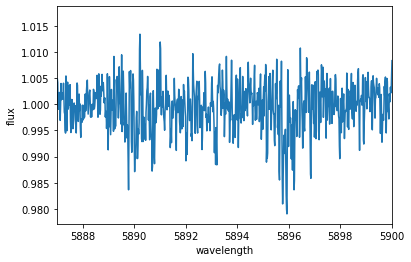

In [ ]:
plt.plot(wave_PRF[0], transmission_spec)
plt.xlabel('wavelength [A]')
plt.ylabel('flux')
plt.xlim(5887.,5900.)
plt.show()